# Figure 1 - Map and T-S + glider campaings

In [6]:
import importlib, os, gc, sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt

import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import matplotlib
import math

from metpy.interpolate import cross_section
import glidertools as gt

# Inteprolation function
def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

import warnings
warnings.filterwarnings('ignore')


# plotting
import seaborn as sns

sns.set(
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=2.5)

fntsiz=24
alp=0.85
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
time_ref=40
cmapi = plt.get_cmap('cmo.ice', 6)

# c_glid=["#8e5cb9","#8baa49","#bd5d43","silver"] #glider colors
c_glid=[cmapi(1),cmapi(2),cmapi(3),cmapi(4)] #glider colors

## Load datasets 

In [2]:
# Glider datasets  -  timeseries
ds1=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG579.nc')
ds2=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG502.nc')
ds3=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/SG510.nc')
ds4=xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057.nc')

# argo data for the climatology T-S (data access: downloaded using argopy; argofetcher from 2000-2022 -- 26-22 north -- 56.2-61.5 east)
argo_=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/datasets/ARGO_GoO_2000_2022.nc')

# Bathymetry from GEBECCO
df_bat = xr.open_dataset('/home/jupyter-estelfont/datasets/bathymetry/gebco_2021_n27.034836007723463_s22.13122092221953_w56.064565535880384_e61.45197185201736.nc')

# GLORYS12 T-S and U-V
df_timeseries_glor= xr.open_dataset('/home/jupyter-estelfont/datasets/glorys_12/CMEMS_2012-2020_t_s.nc')
df_timeseries_glor_uv= xr.open_dataset('/home/jupyter-estelfont/datasets/glorys_12/CMEMS_zos_vo_uo_2000_2020.nc')
    #subselect lat - lon
df_timeseries_glor=df_timeseries_glor.where((df_timeseries_glor.latitude<26) & (df_timeseries_glor.latitude>22) &(df_timeseries_glor.longitude<61.5) & (df_timeseries_glor.longitude>56.2), drop=True)
df_timeseries_glor_uv=df_timeseries_glor_uv.where((df_timeseries_glor.latitude<26) & (df_timeseries_glor.latitude>22) &(df_timeseries_glor.longitude<61.5) & (df_timeseries_glor.longitude>56.2), drop=True)
    #interpolate to higher resolution T-S for nicer resolution when plotting
df_timeseries_glor_interp=df_timeseries_glor.interp(latitude=np.arange(df_timeseries_glor.latitude.min().item(),df_timeseries_glor.latitude.max().item(),0.02), longitude=np.arange(df_timeseries_glor.longitude.min().item(),df_timeseries_glor.longitude.max().item(),0.02))

In [3]:
# Grid data from gliders per profile and depth
def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T

def grid_p(fr , var):
    var_g, x, y=  grid2d(
        fr.profile_num.values,
        fr.pressure.values, 
        fr[var].values, 
        xi=1, yi=yaxis, fn='mean')
    return var_g, x, y

## gridding glider data per profile 1m bins
yaxis=np.arange(0,1000,1)

sa_ds1, _,_ = grid_p(ds1, 'abs_salinity')
ct_ds1, _,_ = grid_p(ds1, 'cons_temp')
o2_ds1, _,_ = grid_p(ds1, 'oxygen_concentration')

sa_ds2, _,_ = grid_p(ds2,  'abs_salinity')
ct_ds2, _,_ = grid_p(ds2, 'cons_temp')
o2_ds2, _,_ = grid_p(ds2, 'oxygen_concentration')

sa_ds3, _,_ = grid_p(ds3,  'abs_salinity')
ct_ds3, _,_ = grid_p(ds3, 'cons_temp')
o2_ds3, _,_ = grid_p(ds3, 'oxygen_concentration')

sa_ds, _,_ = grid_p(ds4, 'abs_salinity')
ct_ds, _,_ = grid_p(ds4, 'cons_temp')
o2_ds, _,_ = grid_p(ds4, 'oxygen_concentration')

## Plotting functions

In [4]:
# PGW water mass fraction function
def watermass_fraction(theta, sa):
    ASW_sa, ASW_theta=gsw.SA_from_SP(34.7, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP(34.7, 0, 58,24), 1,0)#35, 2.9
    PGW_sa, PGW_theta= gsw.SA_from_SP( 40.85, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP( 40.85, 0, 58,24), 29.8,0)
    mW_sa, mW_theta= gsw.SA_from_SP(36.2, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP(36.2, 0, 58,24), 23.5 ,0) #35.57, 15.8 #36, 25.5       #36, 24

    term1=theta-mW_theta-((sa-mW_sa)*(ASW_theta-mW_theta)/(ASW_sa-mW_sa))
    term2=PGW_theta-mW_theta-((PGW_sa-mW_sa)*(ASW_theta-mW_theta)/(ASW_sa-mW_sa))
    fract=term1/term2
    return fract

# Plotting endpoints on a T-S plot
def endpoints_WOA_plot(ax, size, order):
    ASW_end= gsw.SA_from_SP(34.7, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP(34.7, 0, 58,24), 1,0)
    PGW_end= gsw.SA_from_SP( 40.85, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP( 40.85, 0, 58,24), 29.8,0)
    MW_end= gsw.SA_from_SP(36.2, 0, 58,24),  gsw.CT_from_t(gsw.SA_from_SP(36.2, 0, 58,24), 23.5 ,0) #35.57, 15.8 #36, 25.5       #36, 24
    
    colrs=['k','k', 'k'] #["#96bd5c","#9754aa","#c85a41"]  ## green , magenta, red
    ax.scatter(ASW_end[0], ASW_end[1], s=size, zorder=order, c=colrs[0], marker='d')
    ax.scatter(PGW_end[0], PGW_end[1], s=size,zorder=order, c=colrs[2], marker='d')
    ax.scatter(MW_end[0], MW_end[1], s=size,zorder=order, c=colrs[1], marker='d')
    
    ax.text(ASW_end[0]+0.5, ASW_end[1], s='  IODW', c=colrs[0], zorder=order, fontsize=fntsiz, horizontalalignment='center',verticalalignment='center')
    ax.text(PGW_end[0]-0.5, PGW_end[1], s='PGW',c=colrs[2], zorder=order, fontsize=fntsiz,horizontalalignment='center',verticalalignment='center')
    ax.text(MW_end[0]-0.5, MW_end[1], s='ICW', c=colrs[1], zorder=order,fontsize=fntsiz,horizontalalignment='center',verticalalignment='center')
    
# Plotting T-S isolines of PGW and potential density
def ts_ax(ax, fns):
    limto=4
    mins,maxs=34.5, 41.2
    mint,maxt=0, 35
    tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
    Wg, Qg = np.meshgrid(tempL,salL)
    
    sig = gsw.sigma0(Qg, Wg)
    pgw_ts = watermass_fraction(Wg, Qg)
    
    CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=np.arange(18,37,2))
    ax.clabel(CS, fontsize=fns-2, inline=1, fmt='%1.0f')

    CS=ax.contour(Qg, Wg, pgw_ts, colors='green', linestyles='dashed', linewidths=1, levels=np.arange(0,1.1,0.2))
    ax.clabel(CS, fontsize=fns-2, inline=1, fmt='%0.1f')
        
    ax.set_ylabel('Conservative temperature ($^oC$)', fontsize=fns)
    ax.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fns)
    ax.set_xticks([35,36,37,38,39,40, 41])
    ax.set_xlim(34.5, 41.2)
    ax.set_ylim(0, 35)
    return

# truncate colormap for glorys-12 salinity colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmapi = plt.get_cmap('cmo.haline')
new_cmap = truncate_colormap(cmapi, 0.2, 1)

# Figure 1

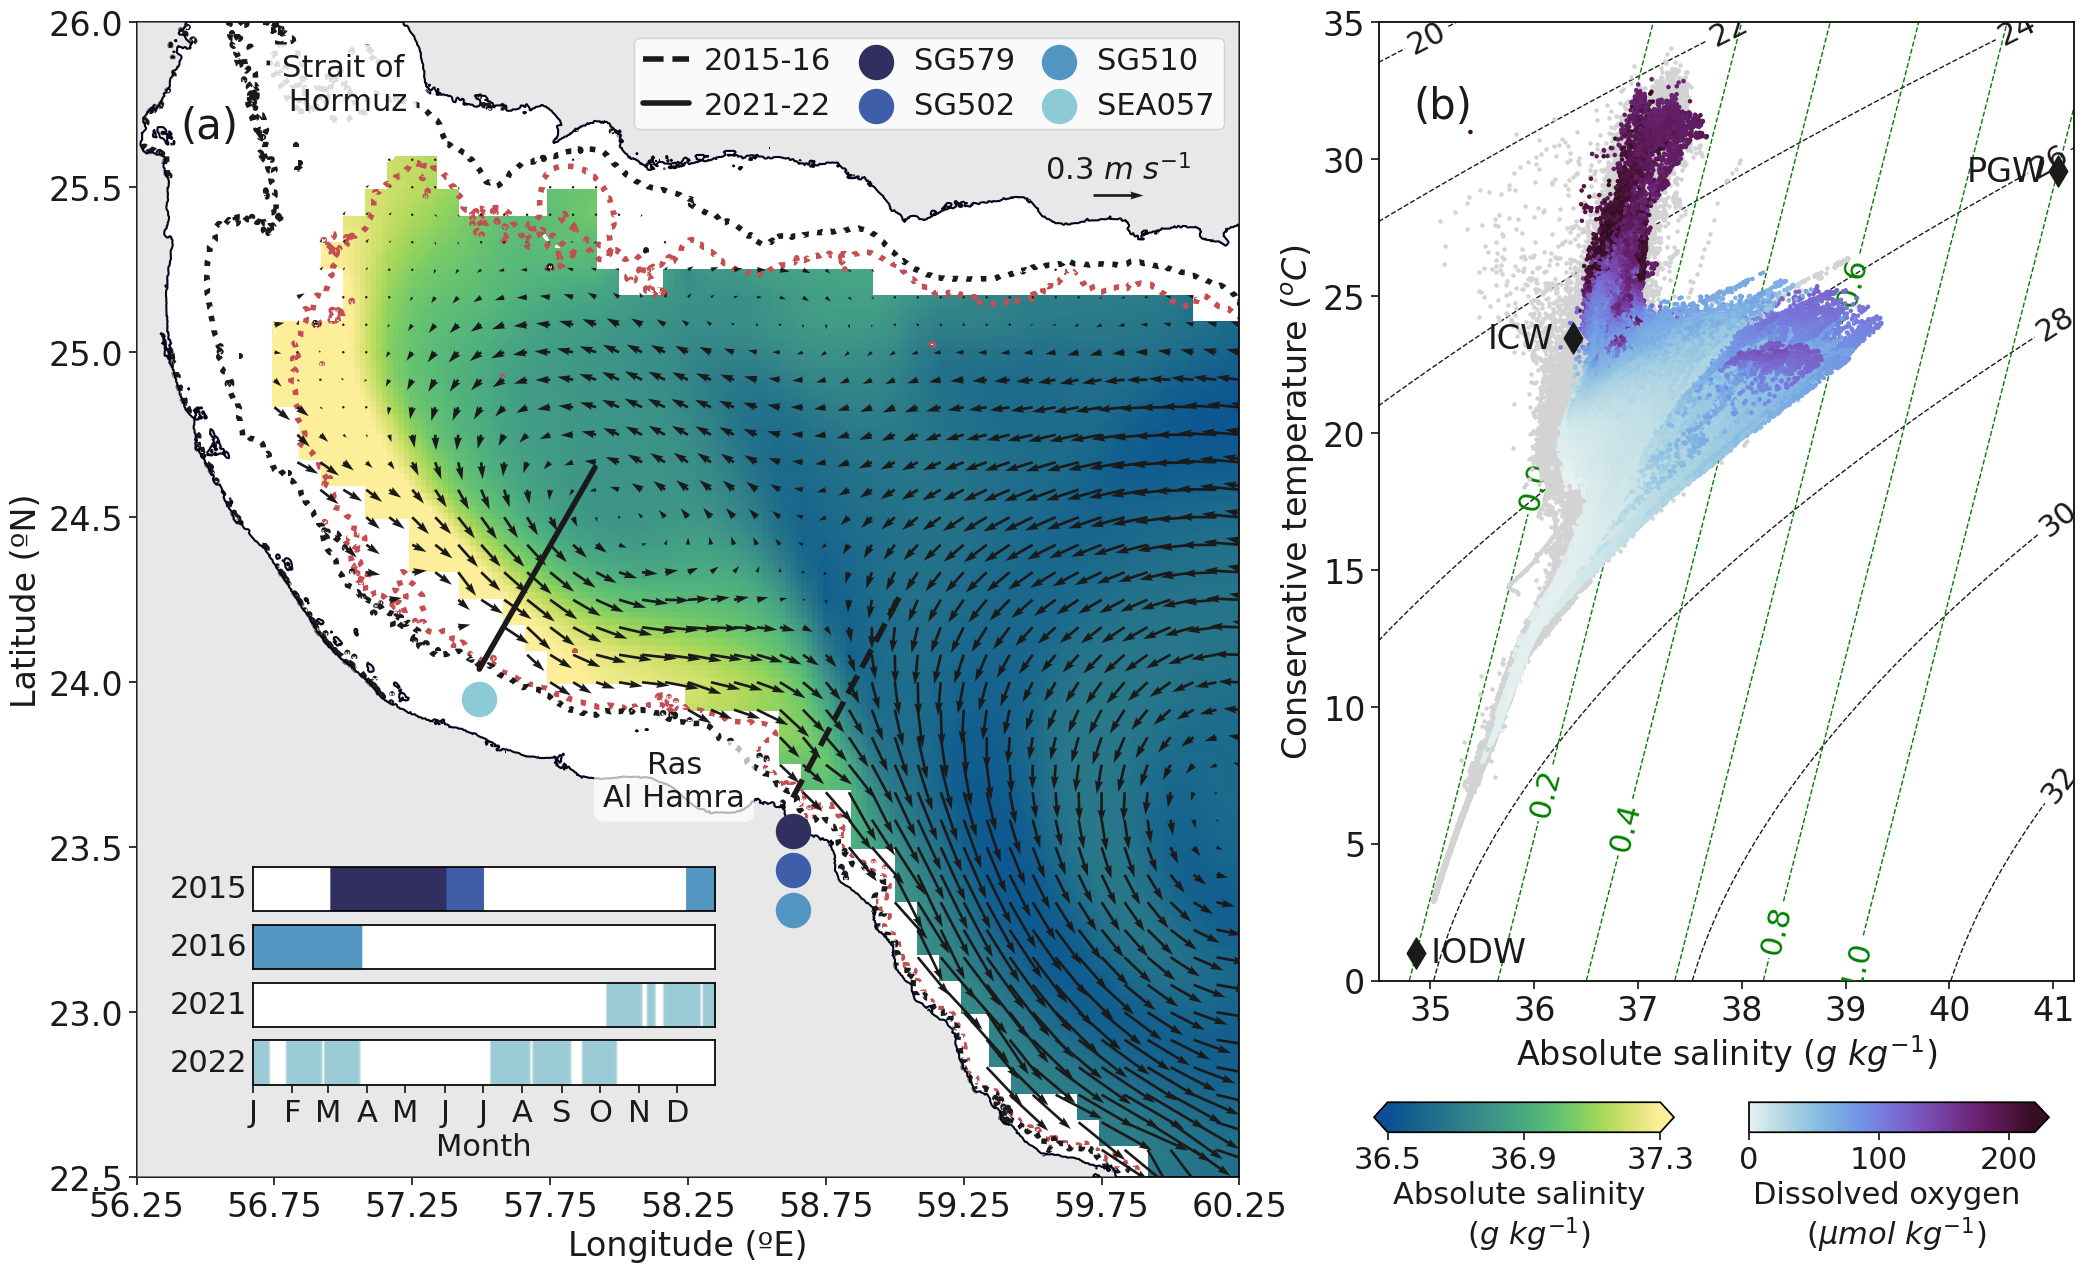

In [7]:
rig=64

gs = GridSpec(100, 100)
fig = plt.figure(figsize=(25,15), constrained_layout=True)

ax1 = fig.add_subplot(gs[:, :57])
t=ax1.text(x=.04,y=.90,s="(" + letters[0] + ')',transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

lolita2=df_timeseries_glor_interp.isel(depth=26).isel(time=time_ref)
lola=df_timeseries_glor_uv.isel(depth=26).isel(time=time_ref)

lola2=df_timeseries_glor.isel(depth=26).isel(time=time_ref)
cmapp = matplotlib.pyplot.get_cmap('cmo.haline')
norm = matplotlib.colors.Normalize(vmin=36.4,vmax=37.2,clip=False)


cs2=ax1.contour(df_bat.lon,df_bat.lat,-df_bat.elevation,colors='r',levels=[ 300], linestyles='dotted', linewidths=4, zorder=1)
ax1.contourf(df_bat.lon,df_bat.lat, df_bat.elevation,  levels=[-200,3000], alpha=1, colors='white', zorder=2)
cs2=ax1.contour(df_bat.lon,df_bat.lat,-df_bat.elevation,colors='k',levels=[ 100], linestyles='dotted', linewidths=4, zorder=3)
ax1.contourf(df_bat.lon,df_bat.lat, df_bat.elevation,  levels=[-1,3000], alpha=0.5, colors='lightgray', zorder=4)
ax1.contour(df_bat.lon,df_bat.lat,df_bat.elevation,levels=[0], linewidths=1.5, zorder=5)

lali=lolita2.so.values
cb=ax1.pcolormesh(lolita2.longitude, lolita2.latitude, lali, cmap=new_cmap, vmin=36.5, vmax=37.3, zorder=0)

cvv=ax1.quiver(lola.longitude, lola.latitude, lola.uo, lola.vo, scale=0.6, scale_units='inches', zorder=20)
qk = ax1.quiverkey(cvv, 0.89, 0.85, 0.3, label='0.3 $m$ $s^{-1}$', fontproperties={'size': fntsiz-2}, labelcolor='k', zorder=25)

ax1.set_xlim(56.25, 60.25)
ax1.set_ylim(22.5, 26)

ax1.set_ylabel('Latitude (ºN)',   fontsize=fntsiz)
ax1.set_xlabel('Longitude (ºE)',   fontsize=fntsiz)

plt.plot([58.63,59.03],[23.65, 24.28], lw=4, c='k', linestyle='dashed', label=r'2015-16', zorder=10)
plt.plot([57.4931,57.9126],[24.0397,24.6507],lw=4,c='k', label='2021-22', zorder=10)
ax1.text(57, 25.81, s='Strait of\n Hormuz', horizontalalignment='center', verticalalignment='center', fontsize=fntsiz-2, c='k', zorder=10,  bbox=dict(facecolor='white', alpha=0.85, edgecolor=None,linewidth=0, boxstyle='round'))

ax1.yaxis.set_ticks(np.arange(22.5,26.5, 0.5))
ax1.xaxis.set_ticks(np.arange(56.25, 60.75, 0.5))

line1=ax1.scatter(58.63,23.55, color=c_glid[0],s=600, label='SG579', zorder=10)
line2=ax1.scatter(58.63,23.43, color=c_glid[1],s=600, label='SG502', zorder=10)
line3=ax1.scatter(58.63,23.31, color=c_glid[2],s=600, label='SG510', zorder=10)
line3=ax1.scatter(57.4931,23.95, color=c_glid[3],s=600, label='SEA057', zorder=10)

plt.legend(prop={'size':fntsiz-2}, ncol=3, loc='upper right', borderpad=0.3, handlelength=1.5, handletextpad=0.5, columnspacing=0.7)

ax1.text(58.2, 23.7, s='Ras\nAl Hamra',horizontalalignment='center', verticalalignment='center', fontsize=fntsiz-2, c='k', zorder=20,  bbox=dict(facecolor='white', alpha=0.7, edgecolor=None,linewidth=0, boxstyle='round'))

ax1.tick_params(axis='both', labelsize=fntsiz)

cbaxes = fig.add_axes([0.62, 0.14, 0.12, 0.02]) 
cbb=plt.colorbar(cb, cax=cbaxes, ticks=np.arange(36.5,37.7,0.4), extend='both', orientation='horizontal')
cbb.set_label('Absolute salinity \n ($g$ $kg^{-1}$)', fontsize=fntsiz-2)
cbb.ax.tick_params(labelsize=fntsiz-2)


ax1 = fig.add_subplot(gs[:83, rig:])
t=ax1.text(x=.05,y=.90,s="(" + letters[1] + ')',transform=ax1.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ts_ax(ax1, fntsiz)
ax1.scatter(argo_.sa, argo_.ct, s=5, c='lightgray', zorder=10)        

cmapp, VMINV, VMAXV, vertres, latres=  cmo.dense,  0,220,5, 2


cc=ax1.scatter(sa_ds[::vertres, ::latres].flatten(), ct_ds[::vertres, ::latres].flatten(), 
                   c=o2_ds[::vertres, ::latres].flatten(),  vmin=VMINV, vmax=VMAXV, s=5, alpha=1, cmap=cmapp, zorder=14)

cc=ax1.scatter(sa_ds1[::vertres, ::latres].flatten(), ct_ds1[::vertres, ::latres].flatten(), 
                   c=o2_ds1[::vertres, ::latres].flatten(),  vmin=VMINV, vmax=VMAXV, s=5, alpha=1, cmap=cmapp, zorder=13)

cc=ax1.scatter(sa_ds2[::vertres, ::latres].flatten(), ct_ds2[::vertres, ::latres].flatten(), 
                   c=o2_ds2[::vertres, ::latres].flatten(),  vmin=VMINV, vmax=VMAXV, s=5, alpha=1, cmap=cmapp, zorder=12)
    
cc=ax1.scatter(sa_ds3[::vertres, ::latres].flatten(), ct_ds3[::vertres, ::latres].flatten(), 
                   c=o2_ds3[::vertres, ::latres].flatten(),  vmin=VMINV, vmax=VMAXV, s=5, alpha=1, cmap=cmapp, zorder=11)
   
endpoints_WOA_plot(ax1, 250, 100)  

ax1.tick_params(axis='both', labelsize=fntsiz)

cbaxes = fig.add_axes([0.77, 0.14, 0.12, 0.02]) 
cbb=plt.colorbar(cc, cax=cbaxes, orientation='horizontal', extend= 'max')
cbb.set_label('Dissolved oxygen \n ($\mu mol$ $kg^{-1}$)', fontsize=fntsiz-2)
cbb.ax.tick_params(labelsize=fntsiz-2)




top=73
rig,lf=6,30
delta=4
ax1 = fig.add_subplot(gs[top:top+delta, rig:lf])

t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax1.scatter(ds1.timestamp.values[::100], np.zeros(len(ds1.timestamp.values[::100])), c=c_glid[0], s=1000, marker='|' )    
ax1.scatter(ds2.timestamp.values[::100], np.zeros(len(ds2.timestamp.values[::100])), c=c_glid[1], s=1000, marker='|' )  
ax1.scatter(ds3.timestamp.values[::100], np.zeros(len(ds3.timestamp.values[::100])), c=c_glid[2], s=1000, marker='|' )  
ax1.set_xlim(pd.to_datetime('2015-01'), pd.to_datetime('2015-12-31'))
ax1.set_xticks([])
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
ax1.set_ylabel('2015', rotation=360, va="center", ha='right', fontsize=fntsiz-2)


ax1 = fig.add_subplot(gs[top+delta+1:top+2*delta+1,rig:lf])
ax1.scatter(ds3.timestamp.values[::100], np.zeros(len(ds3.timestamp.values[::100])), c=c_glid[2], s=1000, marker='|' )  
ax1.set_xlim(pd.to_datetime('2016-01'), pd.to_datetime('2016-12-31'))
ax1.set_xticks([])
ax1.set_ylim(-1,1)
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
ax1.set_ylabel('2016', rotation=360, va="center", ha='right', fontsize=fntsiz-2)

ax1= fig.add_subplot(gs[top+2*delta+2:top+3*delta+2, rig:lf])

ax1.scatter(ds4.time[::10000], np.zeros(len(ds4.time.values[::10000])), c=c_glid[3],alpha=0.1, s=1000, marker='|' ) 
ax1.set_xlim(pd.to_datetime('2021-01'), pd.to_datetime('2021-12-31'))
ax1.set_xticks([])
ax1.set_ylim(-1,1)
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
ax1.set_ylabel('2021', rotation=360, va="center", ha='right', fontsize=fntsiz-2)

 
ax1 = fig.add_subplot(gs[top+3*delta+3:top+4*delta+3, rig:lf])
ax1.scatter(ds4.time[::10000], np.zeros(len(ds4.time.values[::10000])), c=c_glid[3], alpha=0.1, s=1000, marker='|' ) 
ax1.set_xlim(pd.to_datetime('2022-01'), pd.to_datetime('2022-12-31'))
ax1.set_ylim(-1,1)
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
ax1.set_ylabel('2022', rotation=360, va="center", ha='right', fontsize=fntsiz-2)

month_fmt = mdates.DateFormatter('%b')
def m_fmt(x, pos=None):
    return month_fmt(x)[0]

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(m_fmt)
ax1.xaxis.set_major_formatter(m_fmt)
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_xlabel('Month', fontsize=fntsiz-2)

plt.savefig('Figure_1.png', dpi=600)